In [65]:
import webrtcvad
import IPython
import soundfile as sf

import collections
import contextlib
import sys
import wave
import json
import pickle
import torch
import os


from os import listdir
from webrtc_utils import *
    
import torch.nn as nn
import torch.nn.functional as F

from collections import defaultdict
from tqdm import tqdm
import torch.nn as nn

from os import walk
import math
import numpy as np
import librosa

#display waveform
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
import torchaudio

from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn import metrics

In [4]:
with open('../../dev.pkl', 'rb') as f:
    dev_samples = pickle.load(f) 

In [63]:
class CustomDataset(torch.utils.data.Dataset):

    def __init__(self,sample, target):
        self.samples = sample
        self.targets = target
        

    def __getitem__(self, n):
        return self.samples[n].float(), torch.from_numpy(self.targets[n]).float()

    def __len__(self):
        return len(self.samples)

def frame_generator(frame_duration_ms, audio, sample_rate):
    """Generates audio frames from PCM audio data.
    Takes the desired frame duration in milliseconds, the PCM data, and
    the sample rate.
    Yields Frames of the requested duration.
    """
    n = int(sample_rate * (frame_duration_ms / 1000.0) * 2)
    offset = 0
    timestamp = 0.0
    duration = (float(n) / sample_rate) / 2.0
    while offset + n <= len(audio):
        yield Frame(audio[offset:offset + n], timestamp, duration)
        timestamp += duration
        offset += n

    
class LSTMModel(nn.Module):
    def __init__(self, inpud_dim=40, hidden_dim=64, n_layers=2, dropout=0.5):
        super(LSTMModel, self).__init__()

        self.lstm = nn.LSTM(inpud_dim, hidden_dim, num_layers=n_layers, batch_first=True)
        self.layer_norm = nn.LayerNorm(hidden_dim)

        self.fc1 = nn.Linear(hidden_dim, hidden_dim//2)
        self.fc2 = nn.Linear(hidden_dim//2, 1)
        self.dropout1 = nn.Dropout(dropout)
        
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
#         x = self.layer_norm(x)
        x, _ = self.lstm(x)
#         x = self.layer_norm(x)
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        
        return x
    

In [37]:
audio_transforms = nn.Sequential(
    torchaudio.transforms.MFCC(sample_rate=16000, n_mfcc=40, melkwargs={'win_length':400, 'hop_length':160, "center":True, 'n_mels':64}),
    torchaudio.transforms.SlidingWindowCmn(cmn_window=300, norm_vars=True, center=True)
)
def testModel(model, max_samples=10000, device='cuda', test_path='../../test'):
    
    model.to(device)
    test_y = []
    test_X = []
    for key in tqdm(listdir(test_path)[:max_samples]):
        path = os.path.join(test_path, key)
        target = np.array(dev_samples[key])
        signal, samplerate = sf.read(path)
        
        
        mfcc = audio_transforms(torch.from_numpy(signal).float())[:,:-1].transpose(0, 1)
        test_X.append(mfcc)
        test_y.append(target)
    
    
    test_dataset = CustomDataset(test_X, test_y)
    use_cuda = device == 'cuda'
    kwargs = {'num_workers': 0, 'pin_memory': True} if use_cuda else {}

    print('DATASET SIZE: {}'.format(len(test_dataset)))
    
    model.eval()
    preds = []
    for x, _ in tqdm(test_dataset):
        
        with torch.no_grad():
            output = model(torch.unsqueeze(x, 0).float().to(device))
            pred = output.cpu().detach().numpy()
            preds.extend(pred)
    
    return test_y, preds

In [12]:
model = LSTMModel().float()
# model = FeedForwardModel().float()
model.load_state_dict(torch.load('../data/vad.pt'))
model.eval()

LSTMModel(
  (lstm): LSTM(40, 64, num_layers=2, batch_first=True)
  (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [67]:
target, pred = testModel(model, max_samples=10000)

  0%|          | 4/10000 [00:00<04:39, 35.83it/s]

DATASET SIZE: 10000


100%|██████████| 10000/10000 [03:09<00:00, 52.83it/s]


In [69]:
tmp_pred = np.vstack(pred).squeeze(1) > 0.7
print(classification_report(np.hstack(target), tmp_pred.astype(int)))

              precision    recall  f1-score   support

           0       0.58      0.93      0.71   1167129
           1       0.99      0.93      0.96  11448449

    accuracy                           0.93  12615578
   macro avg       0.79      0.93      0.84  12615578
weighted avg       0.95      0.93      0.94  12615578



In [70]:
roc_auc_score(np.hstack(target), np.vstack(pred).squeeze(1))

0.9721720399925425

In [73]:
fpr, tpr, thresholds = roc_curve(np.hstack(target), np.vstack(pred).squeeze(1))

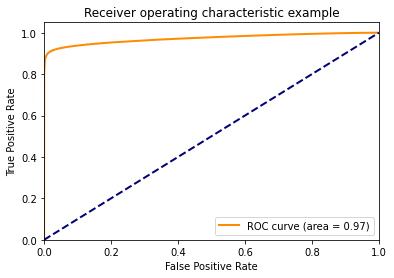

In [71]:
fpr = dict()
tpr = dict()
roc_auc = dict()
# for i in range(1):
#     fpr[i], tpr[i], _ = roc_curve(np.hstack(target), np.vstack(pred).squeeze(1))
#     roc_auc[i] = auc(fpr[i], tpr[i])
    
fpr, tpr, _ = roc_curve(np.hstack(target), np.vstack(pred).squeeze(1))
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Best Threshold=0.908644, G-Mean=0.945


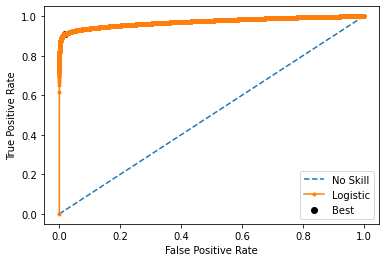

In [74]:
from matplotlib import pyplot
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

## Подсчет FAR and FRR

In [75]:
grid = np.arange(0, 1.01, 0.01)
tmp_pred = np.vstack(pred).squeeze(1)
tmp_target = np.hstack(target)
far = []
frr = []
for thr in grid:
    mask = (tmp_pred > thr).astype(int)
    fa = np.count_nonzero((mask != tmp_target) & (mask == 1))
    far.append(fa / (fa +  np.count_nonzero((mask == tmp_target) & (mask == 0))))
    
    fr = np.count_nonzero((mask != tmp_target) & (mask == 0))
    frr.append(fr / (fr +  np.count_nonzero((mask) == tmp_target) & (mask == 1))))
far = np.array(far) 
frr = np.array(frr)

for i, thr in enumerate(grid):
    if np.abs(far[i] - frr[i]) < 0.005:
        eer = far[i]
        eer_thr = thr

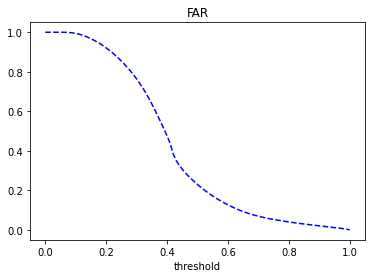

In [76]:
plt.plot(grid, far,'--b')
plt.xlabel('threshold')
plt.title('FAR')
plt.show()

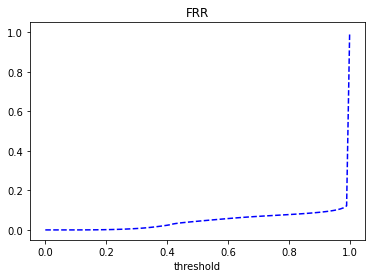

In [77]:
plt.plot(grid,frr,'--b')
plt.xlabel('threshold')
plt.title('FRR')
plt.show()

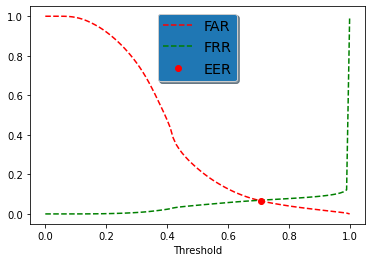

In [78]:
fig, ax = plt.subplots()

ax.plot(grid, far, 'r--', label='FAR')
ax.plot(grid, frr, 'g--', label='FRR')
plt.xlabel('Threshold')
plt.plot(eer_thr, eer,'ro', label='EER') 


legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')


### Три порога при FA=1%, FR=1% and FA=FR

In [79]:
print('fa=1%: {},\nfr=1%: {},\nfa=fa: {},\nerror fa=fr: {}\n'.format(grid[frr < 0.1].max(), grid[far < 0.1].min(), eer_thr, eer * 100))

fa=1%: 0.9500000000000001,
fr=1%: 0.64,
fa=fa: 0.71,
error fa=fr: 6.551546572829567



## Сравнение с бейзлайном

### Предложенная модель

In [80]:
tmp_pred = np.vstack(pred).squeeze(1) > 0.7
print(classification_report(np.hstack(target), tmp_pred.astype(int)))

              precision    recall  f1-score   support

           0       0.58      0.93      0.71   1167129
           1       0.99      0.93      0.96  11448449

    accuracy                           0.93  12615578
   macro avg       0.79      0.93      0.84  12615578
weighted avg       0.95      0.93      0.94  12615578



### Модель webrtc

In [66]:
preds = []
targets = []
vad = webrtcvad.Vad(1)
my_path = '../../test'
for name in tqdm(listdir(my_path)[:10000]):
    vads = []
    path = os.path.join(my_path, name)
    audio, sample_rate = read_wave(path)
    target = dev_samples[name]
    targets.extend(target)
    
    frames = frame_generator(10, audio, sample_rate)
    frames = list(frames)
    
    for frame in frames:
        is_speech = vad.is_speech(frame.bytes, sample_rate)
        speech = 1 if is_speech else 0
        vads.append(speech)
    preds.extend(vads)

print(classification_report(targets, preds))

100%|██████████| 10000/10000 [04:10<00:00, 39.91it/s]


              precision    recall  f1-score   support

           0       0.45      0.24      0.31   1167129
           1       0.93      0.97      0.95  11448449

    accuracy                           0.90  12615578
   macro avg       0.69      0.60      0.63  12615578
weighted avg       0.88      0.90      0.89  12615578

